In [1]:
import sys

# Specify the directory you want to add
custom_path = './..'

# Add the directory to sys.path
if custom_path not in sys.path:
    sys.path.append(custom_path)

from __future__ import absolute_import
import importlib

from copy import copy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from types import SimpleNamespace

import matplotlib.pyplot as plt
from models import MLP
from dsp_utils import seg_time
from plt_utils import plot_by_key,plot_segments

from runners import Runner


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
P0=0
Pplus=5
Pminus=-5
Pchannel=np.nan

T = 1500

playlist = {
'frogs': [(P0,T),((P0,Pplus),T),(P0,T)],
'anti_frogs': [(P0,T),(Pplus,T),(P0,T)],
# 'savings': 3 * [(P0, 500), (Pplus, 500)],
# 'sprecovery': [(P0, 192),
#                (Pplus, 384),
#                (Pminus, 20),
#                (Pchannel, 400)],
# 'spOVRrecovery': [(P0, 192),
#                (Pplus, 1000),
#                (Pminus, 20),
#                (Pchannel, 400)],
# 'evrecovery': [(P0, 192),
#                (Pplus, 384),
#                (Pminus, 20),
#                (Pplus, 20),
#                (Pchannel, 400)],
# 'lng_recovery': [(P0, 192),
#                (Pplus, 384),
#                (Pminus, 500),
#                (Pchannel, 400)]
    }

In [3]:
baseline_settings = {'criterion':'MSE', 'k':[0.5,0,2], 'learning_rate':4e-5, 'sigma_noi':0.0, 'tau_u':10}

model_construct_args =  dict(n_inputs = 3,
                  n_hidden = 512,
                  n_outs = 1,
                  nl = 'tanh')
test_vec1 = np.stack([P0*np.ones(201), 
                    np.zeros(201),
                    np.linspace(-10,10,201)]).T
test_vec2 = np.stack([Pplus*np.ones(201), 
                    np.zeros(201),
                    np.linspace(-10,10,201)]).T
test_vec = np.concatenate([test_vec1,test_vec2])

In [4]:
baseline_runner = Runner(model_construct_args=model_construct_args,
                test_vec=test_vec,
                **baseline_settings)

model reset


In [5]:
we_init = np.copy(
    baseline_runner.model.state_dict()['model.0.weight'].detach().cpu().numpy()[:,2] )

def delta_we(model):
    return  np.linalg.norm(we_init - model.state_dict()['model.0.weight'].detach().cpu().numpy()[:,2])

In [6]:
results = baseline_runner.run_multiple(playlist,extra_measurements = [delta_we])

running scenario: frogs
running scenario: anti_frogs


In [7]:
def do_plots(results,playlist,figsize=(24, 6)):
    plt.figure(figsize=figsize)

    plt.subplot(1,3,2)
    plot_by_key(results, ['frogs','anti_frogs'],visu_offsets = [0, 0.03])
    plt.xlabel('epochs')
    plt.ylabel('u(epoch) [au]')




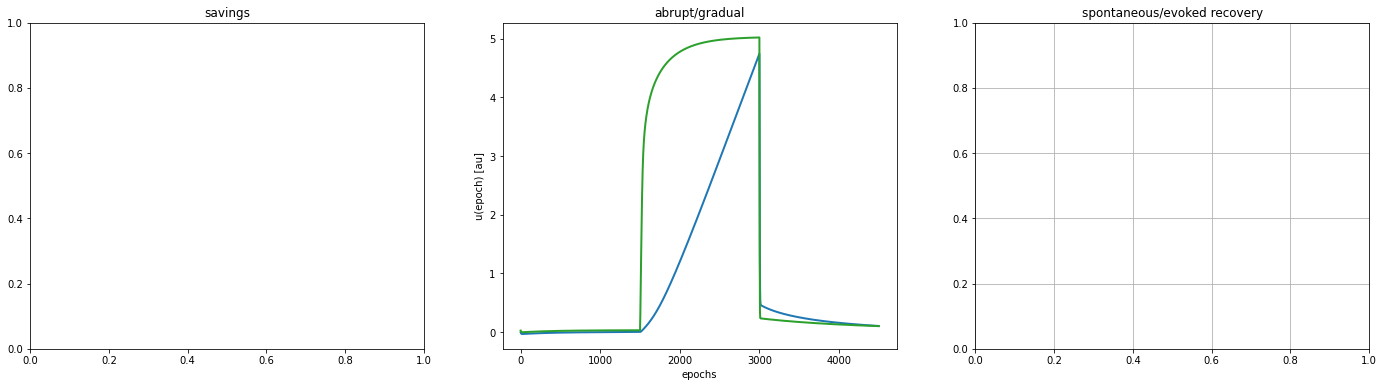

In [8]:
do_plots(results,playlist)
plt.subplot(1,3,1)
plt.title(f'savings')
plt.subplot(1,3,2)
plt.title(f'abrupt/gradual')
plt.subplot(1,3,3)
plt.title(f'spontaneous/evoked recovery')
plt.grid(True)
plt.show()

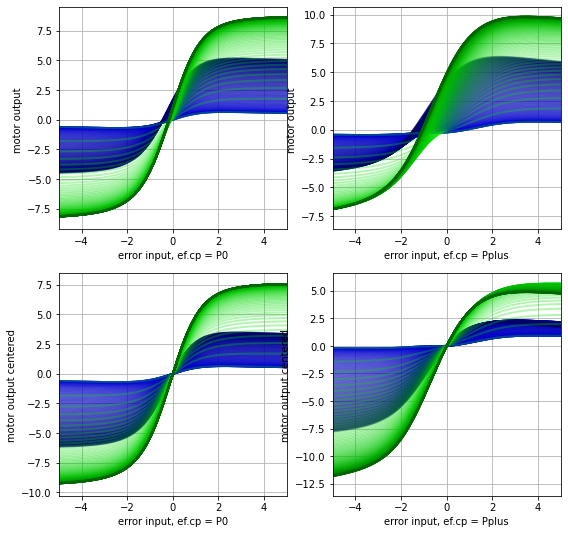

In [9]:
plt.figure(figsize=(9,9))

for tocenter in [False, True]:
    for test_part in [0,1]:

        if test_part==0:
            idxs  = np.arange(len(test_vec)) < len(test_vec1)
        elif test_part==1:
            idxs  = np.arange(len(test_vec)) >= len(test_vec1)
        else:
            raise ValueError
            
        plt.subplot(2,2,2*tocenter+test_part+1)  
        
        for ff,scenario in enumerate(['frogs', 'anti_frogs']):
            foo = playlist[scenario]
            tau = baseline_runner.tau_u
            test_sig = test_vec[idxs,-1]
            test_sig_ref_i = np.where( test_vec[:,-1] == 0.0 )[0][0]
            t_vec_Plus = np.arange(seg_time(foo,1,'start'),seg_time(foo,1,'end'),10)
            for p,t_vec in enumerate([t_vec_Plus]): #, t_vec_Pminus]):
              for i,t in enumerate(t_vec):
                shade = 0.9 - float(i) /2/ len(t_vec)
                ydata = results[scenario].test_output[t].squeeze()[idxs]
                if tocenter:
                    ydata -= ydata[test_sig_ref_i]
                plt.plot(test_sig, ydata,
                        color=[0,shade,0] if ff==1 else [0,0,shade],
                        linewidth=2, alpha=0.3)
            #     plt.ylim([-0.3,0.3])
                plt.xlim([-5,5])
            #     plt.yticks([0])
        plt.xlabel(f"error input, ef.cp = {'P0' if test_part==0 else 'Pplus'}")
        plt.ylabel(f"motor output {'centered' if tocenter else ''}")
        # plt.ylabel('drift velocity')
        plt.grid()

Text(0, 0.5, '|\\delta w_e|')

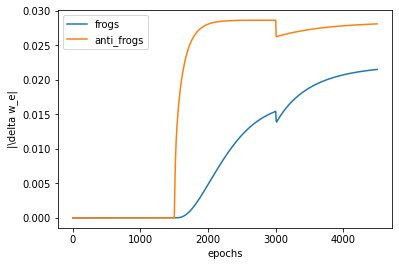

In [10]:
scenarios = ['frogs','anti_frogs']
for scenario in scenarios:
    plt.plot(results[scenario].extra_results)
plt.legend(scenarios)
plt.xlabel('epochs')
plt.ylabel('|\delta w_e|')